# Encoder
Mobilenet V2를 사용한 Encoder

In [1]:
# !wget https://hydranets-data.s3.eu-west-3.amazonaws.com/hydranets-data.zip && unzip -q hydranets-data.zip && mv hydranets-data/* . && rm hydranets-data.zip && rm -rf hydranets-data

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import torch
import torch.nn as nn
import math
import torch.nn.functional as F
from torch.autograd import Variable

# 2 - Creating the HydraNet

We now have 2 DataLoaders: one for training, and one for validation/test.

In the next step, we're going to define our model, following the paper Real-Time Joint Semantic Segmentation and Depth Estimation Using Asymmetric Annotations —— If you haven't read it yet, now is the time.

A Note — This notebook has been adapted from DrSleep, a researcher named Vladimir, who authorized me to adapt it for education purposes. Here's the notebook I'm refering to.



Our model takes an input RGB image, make it go through an encoder, a lightweight refinenet decoder, and then has 2 heads, one for each task.

Things to note:

The only convolutions we'll need will be 3x3 and 1x1
We also need a MaxPooling 5x5
CRP-Blocks are implemented as Skip-Connection Operations
Each Head is made of a 1x1 convolution followed by a 3x3 convolution, only the data and the loss change there

In [3]:
class HydraNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.num_tasks = 2 # segmantation and depth estimation
        self.num_classes = 6 # kitti dataset이 6개만 지원함

In [4]:
hydranet = HydraNet()

## 2.1 Defining the Encoder: A MobileNet v2

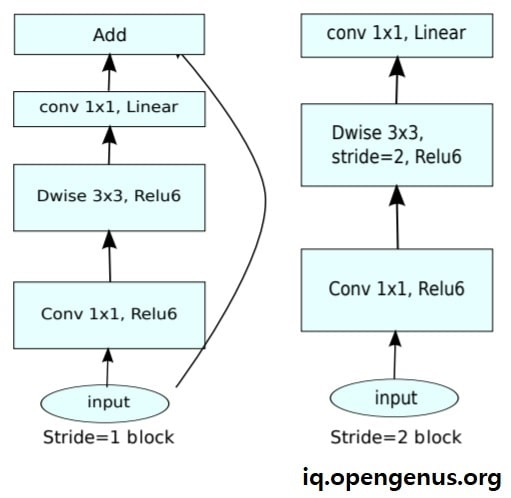

In [5]:
nn.Conv2d??

In [6]:
def conv3x3(in_channels, out_channels, stride=1, dilation=1, groups=1, bias=False):
    """3x3 Convolution: Depthwise: 
    https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
    """
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=dilation, dilation=dilation, bias=bias, groups=groups)

In [7]:
def conv1x1(in_channels, out_channels, stride=1, groups=1, bias=False,):
    "1x1 Convolution: Pointwise"
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=bias, groups=groups)

In [8]:
def batchnorm(num_features):
    """
    https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html
    """
    return nn.BatchNorm2d(num_features, affine=True, eps=1e-5, momentum=0.1)

In [9]:
def convbnrelu(in_channels, out_channels, kernel_size, stride=1, groups=1, act=True):
    "conv-batchnorm-relu"
    if act:
        return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=int(kernel_size / 2.), groups=groups, bias=False),
                             batchnorm(out_channels),
                             nn.ReLU6(inplace=True))
    else:
        return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=int(kernel_size / 2.), groups=groups, bias=False),
                             batchnorm(out_channels))

In [10]:
class InvertedResidualBlock(nn.Module):
    """Inverted Residual Block from https://arxiv.org/abs/1801.04381"""
    def __init__(self, in_planes, out_planes, expansion_factor, stride=1):
        super().__init__() # Python 3
        intermed_planes = in_planes * expansion_factor
        self.residual = (in_planes == out_planes) and (stride == 1) # Boolean/Condition
        self.output = nn.Sequential(convbnrelu(in_planes, intermed_planes, 1), # narrow
                                    convbnrelu(intermed_planes, intermed_planes, 3, stride=stride, groups=intermed_planes), # wide
                                    convbnrelu(intermed_planes, out_planes, 1, act=False)) # narrow

    def forward(self, x):
        #residual = x
        out = self.output(x)
        if self.residual:
            return (out + x)#+residual
        else:
            return out

In [11]:
def define_mobilenet(self):
    mobilenet_config = [[1, 16, 1, 1], # expansion rate, output channels, number of repeats, stride
                    [6, 24, 2, 2],
                    [6, 32, 3, 2],
                    [6, 64, 4, 2],
                    [6, 96, 3, 1],
                    [6, 160, 3, 2],
                    [6, 320, 1, 1],
                    ]
    self.in_channels = 32 # number of input channels
    self.num_layers = len(mobilenet_config)
    self.layer1 = convbnrelu(3, self.in_channels, kernel_size=3, stride=2)
    c_layer = 2
    for t,c,n,s in (mobilenet_config):
        layers = []
        for idx in range(n):
            layers.append(InvertedResidualBlock(self.in_channels, c, expansion_factor=t, stride=s if idx == 0 else 1))
            self.in_channels = c
        setattr(self, 'layer{}'.format(c_layer), nn.Sequential(*layers)) # setattr(object, name, value)
        c_layer += 1

HydraNet.define_mobilenet = define_mobilenet

In [12]:
hydranet.define_mobilenet()

In [13]:
print(hydranet)

HydraNet(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (layer2): Sequential(
    (0): InvertedResidualBlock(
      (output): Sequential(
        (0): Sequential(
          (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (2): Sequential(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affin

## 2.3 Defining the Decoder - A Multi-Task Lightweight RefineNet

[paper](https://arxiv.org/pdf/1810.03272.pdf)

In [14]:
class CRPBlock(nn.Module):
    """CRP definition"""
    def __init__(self, in_planes, out_planes, n_stages, groups=False):
        super().__init__() #Python 3
        for i in range(n_stages):
            setattr(self, '{}_{}'.format(i + 1, 'outvar_dimred'),
                    conv1x1(in_planes if (i == 0) else out_planes,
                            out_planes, stride=1,
                            bias=False, groups=in_planes if groups else 1)) #setattr(object, name, value)

        self.stride = 1
        self.n_stages = n_stages
        self.maxpool = nn.MaxPool2d(kernel_size=5, stride=1, padding=2)

    def forward(self, x):
        top = x
        for i in range(self.n_stages):
            top = self.maxpool(top)
            top = getattr(self, '{}_{}'.format(i + 1, 'outvar_dimred'))(top)#getattr(object, name[, default])
            x = top + x
        return x

In [15]:
def _make_crp(self, in_planes, out_planes, stages, groups=False):
    layers = [CRPBlock(in_planes, out_planes,stages, groups=groups)]
    return nn.Sequential(*layers)

HydraNet._make_crp = _make_crp

In [16]:
def define_lightweight_refinenet(self):
    ## Light-Weight RefineNet ##
    self.conv8 = conv1x1(320, 256, bias=False)
    self.conv7 = conv1x1(160, 256, bias=False)
    self.conv6 = conv1x1(96, 256, bias=False)
    self.conv5 = conv1x1(64, 256, bias=False)
    self.conv4 = conv1x1(32, 256, bias=False)
    self.conv3 = conv1x1(24, 256, bias=False)
    self.crp4 = self._make_crp(256, 256, 4, groups=False)
    self.crp3 = self._make_crp(256, 256, 4, groups=False)
    self.crp2 = self._make_crp(256, 256, 4, groups=False)
    self.crp1 = self._make_crp(256, 256, 4, groups=True)

    self.conv_adapt4 = conv1x1(256, 256, bias=False)
    self.conv_adapt3 = conv1x1(256, 256, bias=False)
    self.conv_adapt2 = conv1x1(256, 256, bias=False)

    self.pre_depth = conv1x1(256, 256, groups=256, bias=False)
    self.depth = conv3x3(256, 1, bias=True)
    self.pre_segm = conv1x1(256, 256, groups=256, bias=False)
    self.segm = conv3x3(256, self.num_classes, bias=True)
    self.relu = nn.ReLU6(inplace=True)

    if self.num_tasks == 3:
        self.pre_normal = conv1x1(256, 256, groups=256, bias=False)
        self.normal = conv3x3(256, 3, bias=True)

HydraNet.define_lightweight_refinenet = define_lightweight_refinenet

In [17]:
hydranet.define_lightweight_refinenet()

## 2.4 Define the HydraNet Forward Function

In [18]:
def forward(self, x):
    # MOBILENET V2
    x = self.layer1(x)
    x = self.layer2(x) # x / 2
    l3 = self.layer3(x) # 24, x / 4
    l4 = self.layer4(l3) # 32, x / 8
    l5 = self.layer5(l4) # 64, x / 16
    l6 = self.layer6(l5) # 96, x / 16
    l7 = self.layer7(l6) # 160, x / 32
    l8 = self.layer8(l7) # 320, x / 32

    # LIGHT-WEIGHT REFINENET
    l8 = self.conv8(l8)
    l7 = self.conv7(l7)
    l7 = self.relu(l8 + l7)
    l7 = self.crp4(l7)
    l7 = self.conv_adapt4(l7)
    l7 = nn.Upsample(size=l6.size()[2:], mode='bilinear', align_corners=False)(l7)

    l6 = self.conv6(l6)
    l5 = self.conv5(l5)
    l5 = self.relu(l5 + l6 + l7)
    l5 = self.crp3(l5)
    l5 = self.conv_adapt3(l5)
    l5 = nn.Upsample(size=l4.size()[2:], mode='bilinear', align_corners=False)(l5)

    l4 = self.conv4(l4)
    l4 = self.relu(l5 + l4)
    l4 = self.crp2(l4)
    l4 = self.conv_adapt2(l4)
    l4 = nn.Upsample(size=l3.size()[2:], mode='bilinear', align_corners=False)(l4)

    l3 = self.conv3(l3)
    l3 = self.relu(l3 + l4)
    l3 = self.crp1(l3)

    # HEADS
    out_segm = self.pre_segm(l3)
    out_segm = self.relu(out_segm)
    out_segm = self.segm(out_segm)

    out_d = self.pre_depth(l3)
    out_d = self.relu(out_d)
    out_d = self.depth(out_d)

    if self.num_tasks == 3:
        out_n = self.pre_normal(l3)
        out_n = self.relu(out_n)
        out_n = self.normal(out_n)
        return out_segm, out_d, out_n
    else:
        return out_segm, out_d

HydraNet.forward = forward

# 3. Run the Model
## 3.1 Load the Model Weights

In [19]:
if torch.cuda.is_available():
    _ = hydranet.cuda()
_ = hydranet.eval()

In [20]:
ckpt = torch.load('ExpKITTI_joint.ckpt')
hydranet.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

In [21]:
IMG_SCALE  = 1./255
IMG_MEAN = np.array([0.485, 0.456, 0.406]).reshape((1, 1, 3))
IMG_STD = np.array([0.229, 0.224, 0.225]).reshape((1, 1, 3))

def prepare_img(img):
    return (img * IMG_SCALE - IMG_MEAN) / IMG_STD

In [22]:
# Pre-processing and post-processing constants #
CMAP = np.load('cmap_kitti.npy')
NUM_CLASSES = 6

In [23]:
print(CMAP)

[[128 128 128]
 [128   0   0]
 [128  64 128]
 [  0   0 192]
 [128 128   0]
 [ 64   0 128]
 [  0   0   0]]


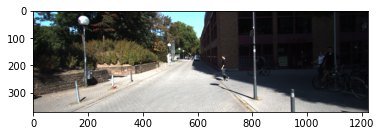

In [24]:
import glob
images_files = glob.glob('data/*.png')
idx = np.random.randint(0, len(images_files))

img_path = images_files[idx]
img = np.array(Image.open(img_path))
plt.imshow(img)
plt.show()

In [25]:
def pipeline(img):
    with torch.no_grad():
        img_var = Variable(torch.from_numpy(prepare_img(img).transpose(2, 0, 1)[None]), requires_grad=False).float()
        if torch.cuda.is_available():
            img_var = img_var.cuda()
        segm, depth = hydranet(img_var)
        segm = cv2.resize(segm[0, :NUM_CLASSES].cpu().data.numpy().transpose(1, 2, 0),
                        img.shape[:2][::-1],
                        interpolation=cv2.INTER_CUBIC)
        depth = cv2.resize(depth[0, 0].cpu().data.numpy(),
                        img.shape[:2][::-1],
                        interpolation=cv2.INTER_CUBIC)
        segm = CMAP[segm.argmax(axis=2)].astype(np.uint8)
        depth = np.abs(depth)
        return depth, segm

In [26]:
depth, segm = pipeline(img)

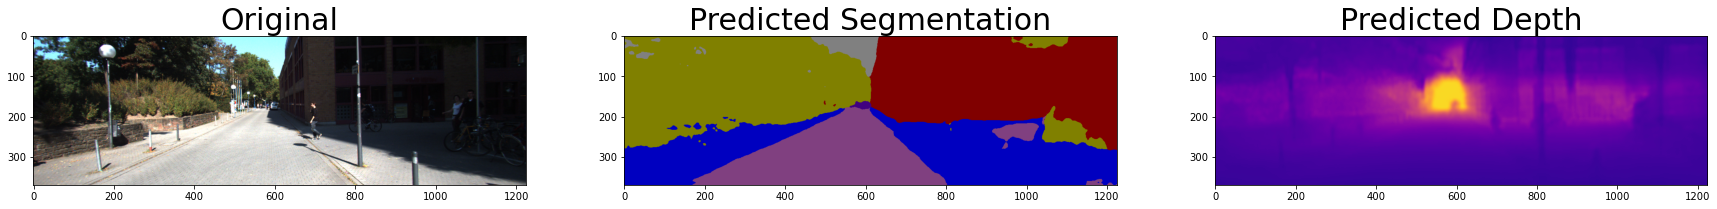

In [27]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,20))
ax1.imshow(img)
ax1.set_title('Original', fontsize=30)
ax2.imshow(segm)
ax2.set_title('Predicted Segmentation', fontsize=30)
ax3.imshow(depth, cmap="plasma", vmin=0, vmax=80)
ax3.set_title("Predicted Depth", fontsize=30)
plt.show()

In [28]:
print(img.shape)
print(depth.shape)
print(segm.shape)

(370, 1224, 3)
(370, 1224)
(370, 1224, 3)


(370, 1224, 3)


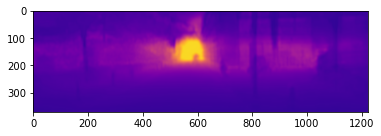

In [29]:
import matplotlib.cm as cm
import matplotlib.colors as co

def depth_to_rgb(depth):
    normalizer = co.Normalize(vmin=0, vmax=80)
    mapper = cm.ScalarMappable(norm=normalizer, cmap='plasma')
    colormapped_im = (mapper.to_rgba(depth)[:, :, :3] * 255).astype(np.uint8)
    return colormapped_im

depth_rgb = depth_to_rgb(depth)
print(depth_rgb.shape)
plt.imshow(depth_rgb)
plt.show()

(370, 1224, 3)
(370, 1224, 3)
(370, 1224, 3)


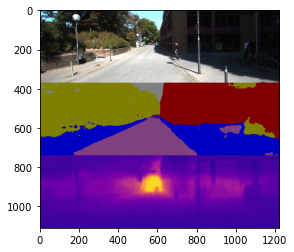

In [30]:
print(img.shape)
print(depth_rgb.shape)
print(segm.shape)
new_img = np.vstack((img, segm, depth_rgb))
plt.imshow(new_img)
plt.show()

In [31]:
def init_weights(m):
    print(m)
    if type(m) == torch.nn.Linear:
#         torch.nn.init.kaiming_uniform_(net.weight)
#         net.bias.data.fill_(0.01)  # tots els bias a 0.01
        m.weight.fill_(1.0)
        print(m.weight)

In [32]:
hydranet.apply(init_weights)

Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU6(inplace=True)
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU6(inplace=True)
)
Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU6(inplace=True)
Sequential(
  (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU6(inplace=True)
)
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU6(inplace=True)
Sequential(
  (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1

HydraNet(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (layer2): Sequential(
    (0): InvertedResidualBlock(
      (output): Sequential(
        (0): Sequential(
          (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (2): Sequential(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affin

In [33]:
video_files = sorted(glob.glob("data/*.png"))

# Build a HydraNet
hydranet = HydraNet()
hydranet.define_mobilenet()
hydranet.define_lightweight_refinenet()
# hydranet._initialize_weights()

# Set the Model to Eval on GPU
if torch.cuda.is_available():
    _ = hydranet.cuda()
_ = hydranet.eval()

# Load the Weights
ckpt = torch.load('ExpKITTI_joint.ckpt')
hydranet.load_state_dict(ckpt['state_dict'])

# Run the pipeline
result_video = []
for idx, img_path in enumerate(video_files):
    image = np.array(Image.open(img_path))
    h, w, _ = image.shape 
    depth, seg = pipeline(image)
    result_video.append(cv2.cvtColor(cv2.vconcat([image, seg, depth_to_rgb(depth)]), cv2.COLOR_BGR2RGB))

out = cv2.VideoWriter('output/out.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 15, (w,3*h))

for i in range(len(result_video)):
    out.write(result_video[i])
out.release()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [35]:
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [36]:
o3d.__version__

'0.15.2'

# RGBD -Fuse the RGB Image and the Depth Map

Fusing RGB image with Depth Map. For that, we'll use Open3D's Class RGBD Image and function create_from_color_and_depth(color, depth)

In [47]:
rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(o3d.geometry.Image(segm), o3d.geometry.Image(depth), convert_rgb_to_intensity=False)

In [48]:
intrinsics = o3d.camera.PinholeCameraIntrinsic(width=1242, height=375, fx=721., fy=721., cx=609., cy=609.)

In [49]:
point_cloud = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsics)
o3d.io.write_point_cloud("test_2.pcd", point_cloud)

True